In [1]:
%reset -f

In [2]:
import torch
%matplotlib inline
from matplotlib import pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
def get_phi(x):
    out = torch.zeros_like(x)
    out[(x >= -1) & (x < 0)] = x[(x >= -1) & (x < 0)] + 1
    out[(x >= 0) & (x <= 1)] = 1 - x[(x >= 0) & (x <= 1)]
    return out


In [4]:
def get_psi(j,k,x):
    return get_phi((2 ** (j+1)) * x - (2*k+1))

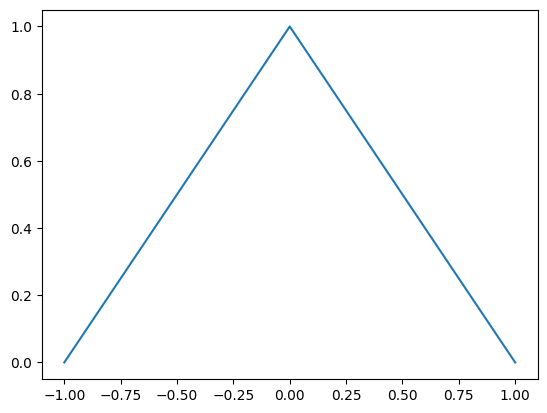

In [5]:
x = torch.arange(-1,1,1/10000)
phi_x = get_phi(x)
plt.plot(x.numpy(), phi_x.numpy())
plt.show()

插值特性：$\phi(k)=\left\{\begin{array}{ll}
1, & k=0 \\
0, & k \neq 0
\end{array}\right.$

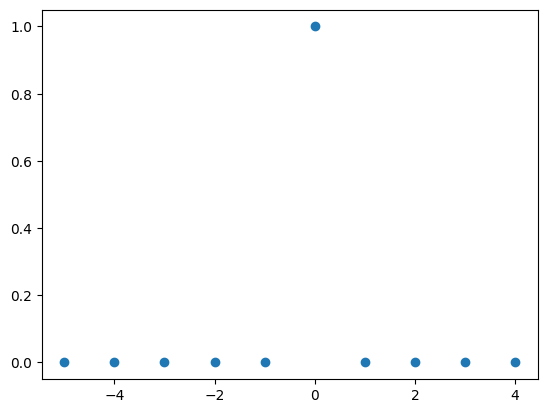

In [6]:
k = torch.arange(-5,5,1)
phi_k = get_phi(k)
plt.scatter(k.numpy(), phi_k.numpy())

双尺度关系：$\phi(x)=\sum\limits_{k \cup Z} \phi(k / 2) \phi(2 x-k)$

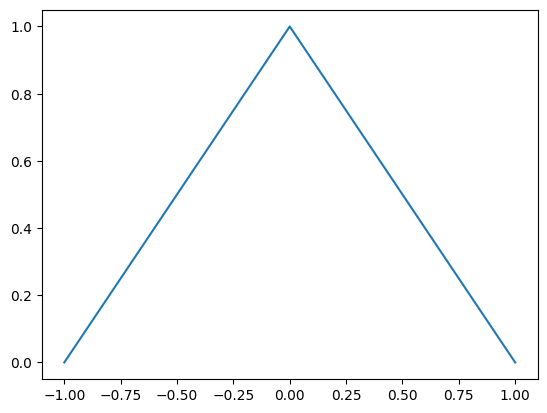

In [7]:
res = 0
for k in range(-5, 5):
    k = torch.tensor(k)
    res += get_phi(k/2)*get_phi(2*x-k)
plt.plot(x.numpy(), res.numpy())

多项式张成：对整数$D\ge0$，$\sum\limits_{k \in Z}C_k\phi(x-k)$能覆盖所有D阶多项式函数

对某一个正实数$R>0$，$\phi$是$R$阶Holder连续的，即
$$\big|\phi(y)-\phi(x)\big|\leq C\big|y-x\big|^R,\quad\forall x,y\in R$$

局部性：$\phi$及其$\lfloor m \rfloor$阶导数是紧支撑的，即：
$$\begin{aligned}\left|\phi^m(x)\right|\leq A_s\left(1+\left|x\right|\right)^{-s},\quad x\in R,\quad s>0,\quad0\leq m\leq\left\lfloor R\right\rfloor\end{aligned}$$

定义尺度函数序列为：$\phi_{j,k}(x)=\phi(2^j\:x-k)\quad k= \{0, 1, ..., 2^j\}$

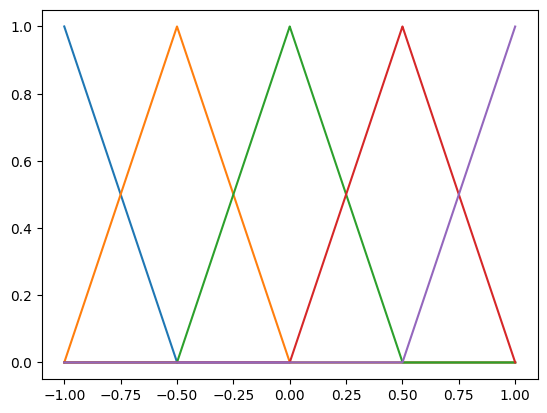

In [8]:
j = 1
for k in range(-2 ** j, 2 ** j + 1, 1):
    phi_jk = get_phi((2 ** j) * x - k)
    plt.plot(x.numpy(), phi_jk.numpy())

In [9]:
n = 2
x_n = torch.tensor(n * 2 ** (-j))
for k in range(n-2,n+3):
    phi_jk_n2_j = get_phi((2 ** j) * x_n - k) ## n == k == 2
    phi_jk_n2_j = 0 if phi_jk_n2_j < 0.0001 else phi_jk_n2_j
    print("n={}, k={}, now phi_jk(n2^-j)={}".format(n, k, phi_jk_n2_j))

n=2, k=0, now phi_jk(n2^-j)=0
n=2, k=1, now phi_jk(n2^-j)=0
n=2, k=2, now phi_jk(n2^-j)=1.0
n=2, k=3, now phi_jk(n2^-j)=0
n=2, k=4, now phi_jk(n2^-j)=0


 $$u_J(x)=\sum\limits^{2^{j_0}}_{k_0=0}u(x_{j_0k_0})\phi_{j_0k_0}(x)+\sum\limits^{J-1}_{j=j_0}\sum\limits_{k \in Z^j}\alpha_{jk}\psi_{jk}(x)$$

In [10]:
def get_Iwt_l(j, f):
    Ijf = 0
    for k in range(-2 ** j, 2 ** j + 1, 1):
        x_jk = torch.tensor(k * (2 ** (-j)))
        f_xjk = f(x_jk)
        phi_jk = get_phi((2 ** j) * x - k)
        Ijf += f_xjk * phi_jk
    return Ijf

In [11]:
def get_alpha_jk(j, k, f, u):
    y_jk = torch.tensor((2*k+1) * (2 ** (-j-1)))
    f_yjk = f(y_jk)
    diff = torch.abs(x - y_jk)
    idx = torch.argmin(diff)
    mask = torch.zeros_like(x)
    mask[idx] = 1
    mask = mask.type(torch.int)
    indices = torch.nonzero(mask).reshape(-1)
    
    return f_yjk - u[indices]

In [24]:
def get_Iwt(j0, J, f):
    if J == 0:
        return get_Iwt_l(J, f)
    j = J-1
    Iwt_r = 0
    u0 = get_Iwt_l(j, f)
    if j == j0:
        for k in range(-2 ** j, 2 ** j, 1):
            alpha_jk = get_alpha_jk(j, k, f, u0)
            psi_jk = get_phi((2 ** (j+1)) * x - (2*k+1))
            Iwt_r += alpha_jk * psi_jk
        return u0 + Iwt_r
    elif j > j0:
        for k in range(-2 ** j, 2 ** j, 1):
            alpha_jk = get_alpha_jk(j, k, f, get_Iwt(j0, j, f))
            psi_jk = get_psi(j, k, x)
            Iwt_r += alpha_jk * psi_jk
        return u0 + Iwt_r
    else:
        return get_Iwt_l(j0, f)

In [25]:
def func(x):
    y = 4*(x ** 3) - 3 * x
    return y

In [30]:
j0 = 1
J = 2
f = func
Iwt = get_Iwt(j0, J, f)

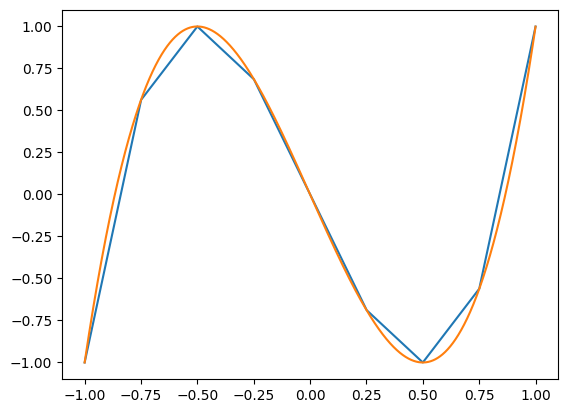

In [31]:
plt.plot(x.numpy(), Iwt.numpy())
plt.plot(x.numpy(), func(x).numpy())
plt.show()